In [1]:
import numpy as np
from scipy.stats import entropy
import json
import collections
import itertools

import powerlaw
from jointpdf.jointpdf import JointProbabilityMatrix
from jointpdf.jointpdf import FullNestedArrayOfProbabilities

from probability_distributions import JointProbabilityMatrixExtended
import probability_distributions
from probability_distributions import ProbabilityArray
from simulate import find_mean_std_mse
import nudge

In [2]:
def effect_of_nudge_1d(distribution, nudge_size):
    """
    Nudge the input variable and calculate the effect on the output variable
    (the KL-devergence of the output variable)
    
    Parameters:
    ----------
    distribution: a numpy array
        It should represent the joint probability distribution of 1 input
        (the first axis) and 1 output variable (the second axis).
    nudge_size: a number
    
    Returns: a number
    """
    probability_array_old = ProbabilityArray(distribution)
    marginal_variable_old = probability_array_old.marginalize(set([0]))
    marginal_function_old = probability_array_old.marginalize(set([1]))
    conditional_joint_old, marginal_labels_old, conditional_labels_old = (
        probability_array_old.find_conditional(set([1]), set([0]))
    )
    marginal_variable_nudged, nudges_states = nudge.nudge(
        marginal_variable_old, nudge_size
    )
    joint_new = ProbabilityArray(probability_distributions.compute_joint(
        marginal_variable_nudged, conditional_joint_old, conditional_labels_old
    ))
    marginal_function_new = joint_new.marginalize(set([1]))  
    kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
    kl_function = entropy(marginal_function_old, marginal_function_new) 
    return kl_variable, kl_function

pdf = JointProbabilityMatrix(1, 10, 'random')
pdf.append_variables_with_target_mi(1, 0.5)
distribution = pdf.joint_probabilities.joint_probabilities
effect_of_nudge_1d(distribution, 0.01)

(0.0016505347184739144, 1.0142294989808624e-05)

Experiment:  
How do mutual information and nudge impact relate for one input variable

In [3]:
#see whether and how mutual information and response to the nudge co-depend
NUMBER_OF_STATES, NUDGE_SIZE = 6, 0.01
mutual_information_sizes = np.arange(0.05, 1, 0.05)
sample_size = 1
effect_nudge_given_mi = {}
for mutual_information_size in mutual_information_sizes:
    print("the mutual information size is {}".format(mutual_information_size))
    nudge_effects = []
    for sample in range(sample_size):
        pdf = JointProbabilityMatrix(1, NUMBER_OF_STATES, 'random')
        pdf.append_variables_with_target_mi(1, mutual_information_size)
        distribution = pdf.joint_probabilities.joint_probabilities
        nudge_effects.append(effect_of_nudge_1d(distribution, 0.01)[1])
        
    effect_nudge_given_mi[mutual_information_size] = nudge_effects
    #with open("back_up2.json", 'w') as f:
    #    json.dump(effect_nudge_given_mi, f)
    
#print(effect_nudge_given_mi)

the mutual information size is 0.05
the mutual information size is 0.1
the mutual information size is 0.15
the mutual information size is 0.2
the mutual information size is 0.25
the mutual information size is 0.3
the mutual information size is 0.35
the mutual information size is 0.4
the mutual information size is 0.45
the mutual information size is 0.5
the mutual information size is 0.55
the mutual information size is 0.6
the mutual information size is 0.65
the mutual information size is 0.7
the mutual information size is 0.75
the mutual information size is 0.8
the mutual information size is 0.85
the mutual information size is 0.9
the mutual information size is 0.95


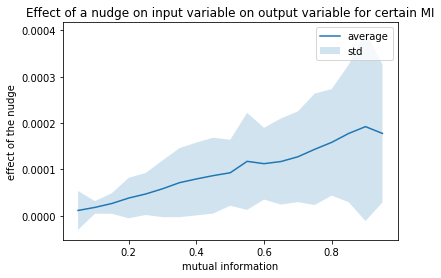

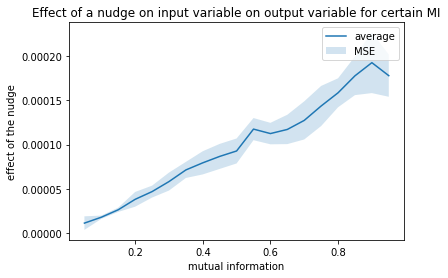

In [4]:
import plotting

with open("data_1_random_input_1_output_diff_MI.json", 'r') as f:
    first = json.load(f)

effect_nudge_given_mi = {}
    
for k, v in first.items():
    effect_nudge_given_mi[float(k)] = v
    
average_effect_nudge_dict = {k:np.mean(v) for k,v in effect_nudge_given_mi.items()}
standard_deviation_effect_nudge_dict = {k:np.std(v) for k,v in effect_nudge_given_mi.items()}

BATCH_SIZE = 30
batches_mean_squared_error = {}
for mi, effect_nudge_list in effect_nudge_given_mi.items():
    batched_estimates = []
    for i in range(len(effect_nudge_list)/BATCH_SIZE):
        batched_estimates.append(
            np.mean(effect_nudge_list[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        )
    batches_mean_squared_error[mi] = np.std(batched_estimates)

batch_std_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(batches_mean_squared_error.items(), key= lambda x: x[0])
)    
average_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(average_effect_nudge_dict.items(), key= lambda x: x[0])
)
std_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(standard_deviation_effect_nudge_dict.items(), key= lambda x: x[0])
)

mi_values = average_effect_nudge_ord_dict.keys()
mean_effect_nudge = average_effect_nudge_ord_dict.values()
std_effect_nudge = std_effect_nudge_ord_dict.values()
batch_std_effect_nudge = batch_std_effect_nudge_ord_dict.values()

xlabel = "mutual information"
ylabel = "effect of the nudge"
title = "Effect of a nudge on input variable on output variable for certain MI"
plotting.plot_mean_and_confidence(
    mi_values, mean_effect_nudge, std_effect_nudge,
    "std", xlabel, ylabel, title
)
plotting.plot_mean_and_confidence(
    mi_values, mean_effect_nudge, batch_std_effect_nudge,
    "MSE", xlabel, ylabel, title
)

mi_values1, mean_effect_nudge1, std_effect_nudge1, batch_std_effect_nudge1 = (
    find_mean_std_mse(effect_nudge_given_mi, batch_size=30)
)

#print(np.allclose(mi_values1, mi_values))
#print(np.allclose(mean_effect_nudge1, mean_effect_nudge))
#print(np.allclose(std_effect_nudge1, std_effect_nudge))
#print(np.allclose(batch_std_effect_nudge1, batch_std_effect_nudge))


In [5]:
import copy

def nudge_distribution_local_non_causal_assume_independence(joint, nudge_label, nudge_size):
    """
    Nudge the marginal and assume independence after the nudge to find the
    new joint.
    
    Parameters:
    ----------
    joint: a numpy array
        Representing a discrete probability distribution
    nudge_label: an integer
    nudge_size: a (small) number
    number_of_nudges: an integer
    
    """
    other_variables_labels = set(range(len(joint.shape))) - set([nudge_label]) 
    marginal_nudge_variable = ProbabilityArray(joint).marginalize(nudge_label)
    marginal_other_variables = ProbabilityArray(joint).marginalize(other_variables_labels)
    marginal_variable_nudged, nudged_states = nudge.nudge(marginal_nudge_variable, nudge_size)
    return probability_distributions.compute_joint_from_independent_marginals(
        marginal_other_variables, marginal_variable_nudged, sorted(list(label_nudged_variable))
    )

def nudge_distribution_local_non_causal(joint, nudge_label, nudge_size, number_of_nudges):
    """
    nudge the the variable with nudge label while keeping the 
    marginal of the other variables constant
    
    Parameters:
    ----------
    joint: a numpy array
        Representing a discrete probability distribution
    nudge_label: an integer
    nudge_size: a (small) number
    number_of_nudges: an integer
    
    Returns: a numpy array, representing the nudged probability distribution
    
    """
    nudged_joint = np.copy(joint)
    nudged_joint = nudged_joint.swapaxes(nudge_label, len(joint.shape)-1)
    nudge_states = nudge.select_random_states(nudged_joint.shape[:-1], number_of_nudges) 
    
    nudged_states_marginal = np.random.choice(joint.shape[nudge_label], 2, replace=False)
    nudge_state_plus, nudge_state_minus = nudged_states_marginal[0], nudged_states_marginal[1]   
    for state in nudge_states:
        plus_state = tuple(copy.copy(state) + [nudge_state_plus])
        minus_state = tuple(copy.copy(state) + [nudge_state_minus])        
        size = min(nudged_joint[minus_state], 1-nudged_joint[plus_state], nudge_size)
        nudged_joint[plus_state] += size
        nudged_joint[minus_state] -= size
    
    nudged_joint = nudged_joint.swapaxes(nudge_label, len(joint.shape)-1)
    return nudged_joint
    
def impact_nudge_causal_output(distribution, function_indices, new_input_distribution):
    """
    Calculate the impact of a nudge of the input distribution on the output. 
    Assuming the output is causally determined using using the input.
    
    Parameters:
    ----------
    distribution: a ProbabilityArray object
    function_indices: a set of integers
    new_input_distribution: a numpy array
        It represents the input distribution after the nudge
    
    Returns:
    -------
    A numpy array representing a probability distribution
    
    """
    variable_indices = set(range(len(distribution.probability_distribution.shape))) - function_indices
    marginal_output_old = distribution.marginalize(function_indices)
    conditional, marginal_labels, conditional_labels = (
        distribution.find_conditional(function_indices, variable_indices)
    )
    distribution_new = ProbabilityArray(probability_distributions.compute_joint(
        new_input_distribution, conditional, conditional_labels
    ))
    marginal_output_new = distribution_new.marginalize(function_indices)  
    kl_divergence = entropy(marginal_output_old, marginal_output_new) 
    return kl_divergence

def calculate_amount_and_size_nudges(total_nudge_size, number_of_states):
    """
    Calculate the nudge size and the number of nudges that need to be performed 
    to nudge a variable with the total nudge size
    
    Parameters:
    ----------
    total_nudge_size: a number
        How much the variable need to be nudged
    number_of_states: a number
        The total number of states of the joint distribution
        
    Returns: local_nudge, number_of_nudges
    -------
    local_nudge: a number 
        The size of the local nudge to be performed on the joint distribution
    number_of_nudges: integer
        How often the nudge need to be performed
    
    """
    max_local_nudge = min(total_nudge_size, 0.1/number_of_states)
    number_of_nudges = max(int(total_nudge_size/max_local_nudge), 1)
    return max_local_nudge, number_of_nudges
    
def calculate_nudge_impact(number_of_variables, number_of_states, total_nudge_size):
    """ 
    For now calculate the impact of a local non-causal nudge on the input variables
    on the completely causally determined output variable
    
    Parameters:
    ----------
    number_of_variables: integer
    number_of_states: integer
    total_nudge_size: number
    
    """
    total_number_of_states = number_of_states**number_of_variables
    max_local_nudge, number_of_nudges = calculate_amount_and_size_nudges(
        total_nudge_size, total_number_of_states
    )
    pdf = JointProbabilityMatrix(number_of_variables+1, number_of_states, 'random')
    distribution = ProbabilityArray(pdf.joint_probabilities.joint_probabilities)
    function_labels, label_nudged_variable = set([number_of_variables]), 0
    input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
    input_distribution = distribution.marginalize(input_variable_labels)
    
    new_input_distribution = nudge_distribution_local_non_causal(
        input_distribution, 0, max_local_nudge, number_of_nudges
    )
    return impact_nudge_causal_output(distribution, function_labels,
                                      new_input_distribution)

number_of_variables = 1
NUMBER_OF_STATES = 5
TOTAL_NUDGE_SIZE = 0.005    
nudge_impact = calculate_nudge_impact(number_of_variables, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE)
print(nudge_impact)

9.36070388204e-06


Experiment:
The impact of a nudge on an input variable (with no causal impact on the other input variables)
on the output variable, for different number of input variables.


In [6]:
MAX_NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 6, 5, 0.01
NUMBER_OF_SAMPLES = 10
impact_nudge_dict = {}

for number_of_variables in range(1, MAX_NUMBER_OF_VARIABLES, 1):
    print(number_of_variables)
    impact_nudges = []
    for i in range(NUMBER_OF_SAMPLES):
        print("sample number {}".format(i))
        impact_nudges.append(
            calculate_nudge_impact(number_of_variables, 
                                   NUMBER_OF_STATES, 
                                   TOTAL_NUDGE_SIZE)
        )
    
    impact_nudge_dict[number_of_variables] = impact_nudges
    #with open("back_up_number_variables_output.json", 'w') as f:
    #    json.dump(impact_nudge_dict, f)

#print(impact_nudge_dict) 


1
sample number 0
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
2
sample number 0
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
3
sample number 0
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
4
sample number 0
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
5
sample number 0
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9


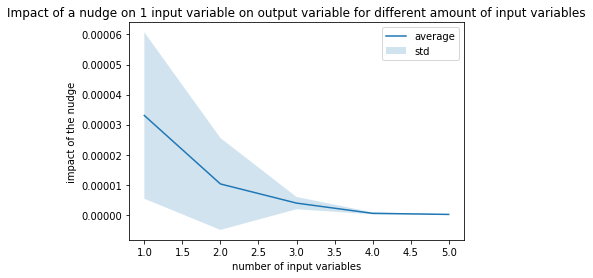

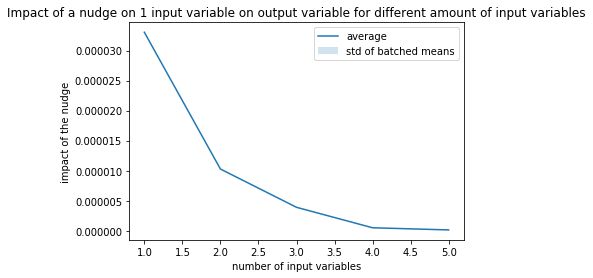

(0.12252473709495071, 0.92458114113495704)
(-0.050253123520263898, 0.87132228693646507)


Calculating best minimal value for power law fit
/home/derkjan/Documents/academics_UVA/master_thesis/venv_python2_thesis/local/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [7]:
variable_range, mean_impact_nudge, std_impact_nudge, batches_std = (
    find_mean_std_mse(impact_nudge_dict, 10)
)

xlabel = "number of input variables"
ylabel = "impact of the nudge"
title = "Impact of a nudge on 1 input variable on output variable for different amount of input variables"
plotting.plot_mean_and_confidence(
    variable_range, mean_impact_nudge, std_impact_nudge,
    "std", xlabel, ylabel, title
)

plotting.plot_mean_and_confidence(
    variable_range, mean_impact_nudge, batches_std,
    "std of batched means", xlabel, ylabel, title
)

fit = powerlaw.Fit(mean_impact_nudge)
print(fit.distribution_compare("power_law", "exponential"))
print(fit.distribution_compare("power_law", "lognormal"))

Experiment:
The relation between nudge impact and the mutual information between the output variable and
the nudged input variable.


In [16]:
import information_theory
from information_theory import calculate_mutual_information

NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 2, 5, 0.01
NUMBER_OF_SAMPLES = 100

local_nudge, number_of_nudges = calculate_amount_and_size_nudges(
    TOTAL_NUDGE_SIZE, NUMBER_OF_STATES**NUMBER_OF_VARIABLES
)
impact_nudges_and_mi = []
for i in range(NUMBER_OF_SAMPLES):
    print("sample number {}".format(i))
    
    #calculate the distribution
    pdf = JointProbabilityMatrix(number_of_variables+1, NUMBER_OF_STATES, 'random')
    distribution = ProbabilityArray(pdf.joint_probabilities.joint_probabilities)
    function_label, label_nudged_variable = NUMBER_OF_VARIABLES, 0
    function_labels = set([function_label])
    input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
    
    #calculate mutual information
    mutual_information = calculate_mutual_information(distribution, 
                                                      set([function_label]),
                                                      set([label_nudged_variable]))
    
    #calculate_nudge_impact
    input_distribution = distribution.marginalize(input_variable_labels)
    new_input_distribution = nudge_distribution_local_non_causal(
        input_distribution, 0, local_nudge, number_of_nudges
    )
    nudge_impact = impact_nudge_causal_output(distribution, function_labels,
                                              new_input_distribution)
    
    impact_nudges_and_mi.append((nudge_impact, mutual_information))


sample number 0
sample number 1
sample number 2
sample number 3
sample number 4
sample number 5
sample number 6
sample number 7
sample number 8
sample number 9
sample number 10
sample number 11
sample number 12
sample number 13
sample number 14
sample number 15
sample number 16
sample number 17
sample number 18
sample number 19
sample number 20
sample number 21
sample number 22
sample number 23
sample number 24
sample number 25
sample number 26
sample number 27
sample number 28
sample number 29
sample number 30
sample number 31
sample number 32
sample number 33
sample number 34
sample number 35
sample number 36
sample number 37
sample number 38
sample number 39
sample number 40
sample number 41
sample number 42
sample number 43
sample number 44
sample number 45
sample number 46
sample number 47
sample number 48
sample number 49
sample number 50
sample number 51
sample number 52
sample number 53
sample number 54
sample number 55
sample number 56
sample number 57
sample number 58
sample 

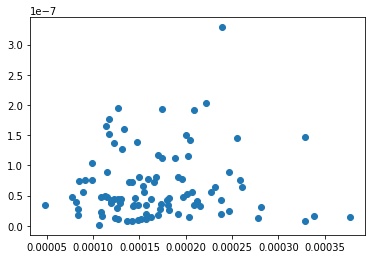

In [17]:
import matplotlib.pyplot as plt

impact_nudges = [item[0] for item in impact_nudges_and_mi] 
mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
plt.plot(mutual_information_sizes, impact_nudges, 'o')
plt.show()
    
    

In [ ]:
import numpy as np

probability_array_tryout = FullNestedArrayOfProbabilities(
    np.array(
      [
        [
          [
            [0.2, 0.1]          
          ],
          [
            [0.05, 0.05]
          ]
        ],
        [
          [
            [0.3, 0.05] 
          ],
          [
            [0.15, 0.1] 
          ]
        ],
      ]
    )
) 

In [ ]:
def conditional_distribution(self, selected_indices, conditional_indices):
    """create the conditional distribution for the selected_indices given 
    the conditional_indices for the joint_distribution
    
    Parameters:
    ----------
    joint_distribution: numpy array
    selected_indices: list of integers
    conditional_indices: list of integers
    
    Returns:
    -------
    
    """
    joint_distribution = self.marginalize_distribution(selected_indices+conditional_indices)
    marginal_conditional = self.marginalize_distribution(conditional_indices)
    conditional_distribution = np.copy(joint_distribution) 
    it = np.iter(joint_distribution, flags='multi_index')
    while not it.finished:
        conditional_arguments = tuple([it.multi_index[i] for i in conditional_indices])
        conditional_distribution[it.multi_index] = (
            conditional_distribution[it.multi_index] /
            marginal_conditional[conditional_arguments]
        )
        it.iternext()
        
    return conditional_distribution
        

In [ ]:
import numpy as np

tryout = np.arange(2**10).reshape([2]*10)
#print(tryout)
a = [1, 3, 4, 5, 9]
total_variables = 10
b = np.moveaxis(tryout, a, range(total_variables-len(a), total_variables, 1))
c = np.array([[1,10],[100,1000]])
b = b*c
#tryout = np.moveaxis(b, range(total_variables-len(a), total_variables, 1), a)
print(tryout)


#tryout = b*c
#np.moveaxis(tryout, range(total_variables-len(a), total_variables, 1), a)
